In [6]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [7]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [8]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [9]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [10]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

/var/folders/pp/tn2y0zwd30j8047f1n1vkprm0000gn/T/ipykernel_69103/4196587217.py:4: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [15]:
# View all of the classes that automap found
reflected_classes = Base.classes.keys()
print(reflected_classes)

['station', 'measurement']


In [16]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [17]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [21]:
# Find the most recent date in the data set.
latest_date_query = session.query(Measurement.date).\
    order_by(Measurement.date.desc()).first()
print(latest_date_query)

('2017-08-23',)


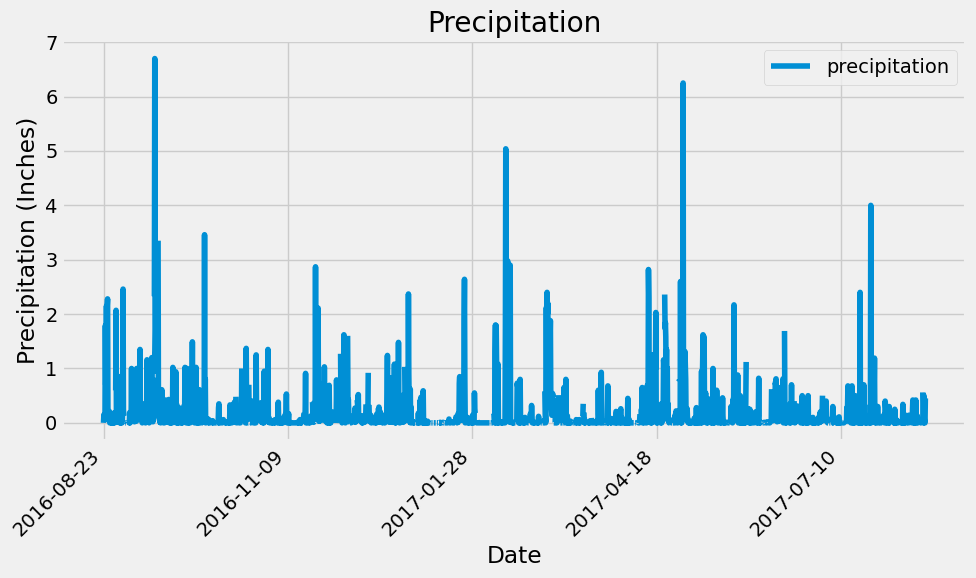

In [24]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
latest_date_query = session.query(func.max(Measurement.date)).scalar()
latest_date = dt.datetime.strptime(latest_date_query, '%Y-%m-%d').date()
# Calculate the date one year from the last date in data set.
one_year_ago = latest_date - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_year_ago).\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(precipitation_data, columns=['date', 'precipitation'])

# Sort the dataframe by date
precipitation_df = precipitation_df.sort_values(by='date')
# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot(x='date', y='precipitation', figsize=(10,6), legend=True, title='Precipitation')
plt.xlabel('Date')
plt.ylabel('Precipitation (Inches)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [32]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_stats = precipitation_df['precipitation'].describe()
precipitation_stats_df = pd.DataFrame(precipitation_stats, columns=['precipitation'])
precipitation_stats_df

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [35]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station)).scalar()
result = [(total_stations,)]
print(result)

[(9,)]


In [37]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations_query = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).\
    all()
active_stations_query

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [38]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station_id = 'USC00519281'  # Replace with the actual ID from your query
temperature_stats = session.query(
    func.min(Measurement.tobs).label('min_temp'),
    func.max(Measurement.tobs).label('max_temp'),
    func.avg(Measurement.tobs).label('avg_temp')
).filter(Measurement.station == most_active_station_id).all()

# Format the results as a list of tuples
result = [(temperature_stats[0].min_temp, temperature_stats[0].max_temp, temperature_stats[0].avg_temp)]

# Display the results
print(result)

[(54.0, 85.0, 71.66378066378067)]


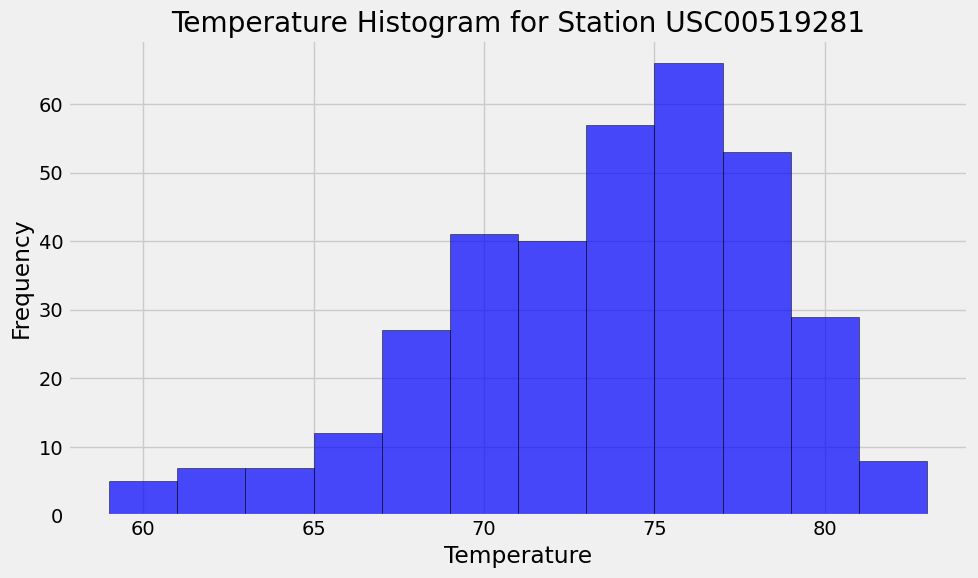

In [49]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
latest_date_query = session.query(func.max(Measurement.date)).scalar()
latest_date = dt.datetime.strptime(latest_date_query, '%Y-%m-%d').date()
one_year_ago = latest_date - dt.timedelta(days=365)

# Retrieve temperature data for the last 12 months
temperature_data = session.query(Measurement.tobs).\
    filter(Measurement.station == most_active_station_id).\
    filter(Measurement.date >= one_year_ago).\
    order_by(Measurement.date).all()

# Convert the query results to a DataFrame
temperature_df = pd.DataFrame(temperature_data, columns=['tobs'])

# Plot the results as a histogram
plt.figure(figsize=(10, 6))
plt.hist(temperature_df['tobs'], bins=12, alpha=0.7, color='blue', edgecolor='black')
plt.title(f'Temperature Histogram for Station {most_active_station_id}')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Close Session

In [50]:
# Close Session
session.close()